In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
sns.set(
    font_scale =2,
    style      ='whitegrid',
    rc         ={'figure.figsize':(20,7)}
)

In [3]:
customers = pd.read_csv('olist_customers_dataset.csv')

orders    = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp',
                                                                 'order_approved_at',
                                                                 'order_delivered_carrier_date', 
                                                                 'order_delivered_customer_date',
                                                                 'order_estimated_delivery_date'])

items     = pd.read_csv('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])

In [4]:
customers.isna().sum()
# Проверяем пустые значения

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [5]:
orders.isna().sum()
# Проверяем пустые значения

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [6]:
items.isna().sum()
# Проверяем пустые значения

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [7]:
customers.duplicated().sum()
# Проверяем дублирующиеся данные

0

In [8]:
orders.duplicated().sum()
# Проверяем дублирующиеся данные

0

In [9]:
items.duplicated().sum()
# Проверяем дублирующиеся данные

0

В данных есть аномалии, такие как: 'order_delivered_carrier_date > order_delivered_customer_date' и 'order_purchase_timestamp > order_delivered_carrier_date' спишем их на ошибку или сбой в системе. 

Есть несколько заказов, у которых есть дата доставки, но статус == недействителен/отменен

Также в данных есть доставленные заказы без подтверждения оплаты(14), возможно статус забыли обновить, на всякий случай их считать тоже не будем, к тому же их не так много.

# Сколько у нас пользователей, которые совершили покупку только один раз?

За покупку будем считать доставленные заказы с подтвержденным фактом оплаты. 
В данных много заказов доставленных с большим опозданием, поэтому заказы доставленные после 45 дней от ожидаемой даты доставки, за покупку не считаем.

In [10]:
orders['final_date'] = orders['order_estimated_delivery_date'] + pd.Timedelta(days=45)
# Создаем столбец для сравнения даты доставки и максимальной даты

In [11]:
purchases = orders.query("order_status == 'delivered' and order_delivered_customer_date < final_date") \
                  .dropna(subset=['order_approved_at'])
# Фильтруем доставленные в срок заказы с оплатой

In [12]:
purchases_by_customers = pd.merge(purchases[['customer_id', 'order_id']], 
                                  customers[['customer_id', 'customer_unique_id']], 
                                  on='customer_id')
# Мерджим данные для подсчета количества заказов

In [13]:
only_one_purchase = purchases_by_customers.groupby('customer_unique_id', as_index=False) \
                                          .order_id.count() \
                                          .rename(columns={'order_id':'orders'}) \
                                          .query('orders == 1')

only_one_purchase.head(5)
# Получаем количество пользователей, которые совершили покупку только один раз(90386)

,customer_unique_id,orders
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


# Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

За сегодняшнюю дату будем принимать максимальную дату в датафрейме orders.

In [14]:
orders['month_start'] = orders['order_purchase_timestamp'].apply(lambda x: x - pd.offsets.MonthBegin(1)).dt.date
# Создаем столбец начала месяца для дальнейшей группировки

In [15]:
undelivered_orders = orders[~orders['order_id'].isin(purchases['order_id'])] \
                     .query("final_date < order_purchase_timestamp.max()")
# Находим недоставленные заказы и убираем те, которые еще могут быть доставлены в срок

In [16]:
undelivered_orders.groupby('month_start', as_index=False) \
                  .order_id.count().order_id.sum() / orders.month_start.nunique()
# Находим сколько заказов за месяц в среднем не доставляется за все время, делим на количество месяцев в датафрейме

123.12

In [17]:
undelivered_by_status = undelivered_orders.groupby('order_status', as_index=False) \
                                          .order_id.count() \
                                          .rename(columns={'order_id':'orders'})

undelivered_by_status['avg_by_months'] = undelivered_by_status['orders'] / 25
# Группируем не доставленные заказы по статусам

In [18]:
lost = undelivered_by_status.loc[~undelivered_by_status['order_status'] \
                            .isin(['canceled', 'unavailable', 'delivered', 'shipped']), 'orders'].sum()

undelivered_group = pd.DataFrame({
    'order_status': ['canceled', 'unavailable', 'delivered', 'shipped', 'lost'],
    'orders': [undelivered_by_status.loc[undelivered_by_status['order_status'] == 'canceled', 'orders'].iloc[0],
               undelivered_by_status.loc[undelivered_by_status['order_status'] == 'unavailable', 'orders'].iloc[0],
               undelivered_by_status.loc[undelivered_by_status['order_status'] == 'delivered', 'orders'].iloc[0],
               undelivered_by_status.loc[undelivered_by_status['order_status'] == 'shipped', 'orders'].iloc[0], lost]
})

undelivered_group['avg_by_months'] = undelivered_group['orders'] / 25
# Новый датафрейм с недоставленными заказами, и средним числом недоставленных заказов за все время

In [19]:
undelivered_group
# Canceled - отмененные, 
# Unavailable - недоступные, 
# Delivered - доставленные с задержкой, 
# Shipped - отправленные, но потерявшиеся, либо долгая доставка
# Lost - застрявшие на начальных этапах, либо не оплатили, либо отменили по разным причинам, а статус просто не обновили

,order_status,orders,avg_by_months
0,canceled,563,22.52
1,unavailable,609,24.36
2,delivered,181,7.24
3,shipped,1103,44.12
4,lost,622,24.88


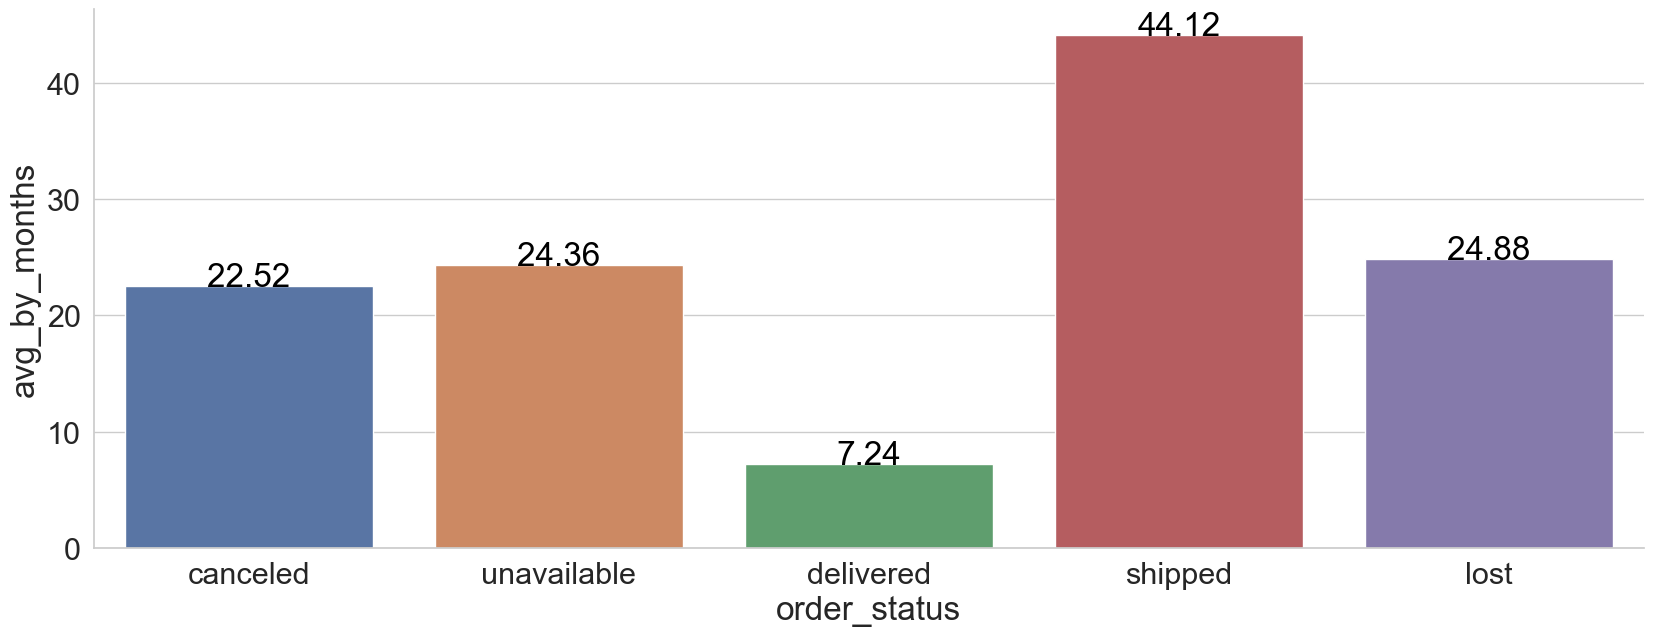

In [20]:
ax1 = sns.barplot(data=undelivered_group, y='avg_by_months', x='order_status')
for index, row in undelivered_group.iterrows():
    ax1.text(row.name, row.avg_by_months, round(row.avg_by_months, 2), color='black', ha="center")
sns.despine()
sns.despine()

Заказы, застрявшие на начальных этапах, либо не оплатили, либо отменили по разным причинам, а статус просто не обновили.
Отправленные заказы либо потеряны, либо прошел максимальный срок возможной доставки.
Заказы со статусом 'delivered' были доставлены не в срок, поэтому их тоже посчитал как не доставленные.

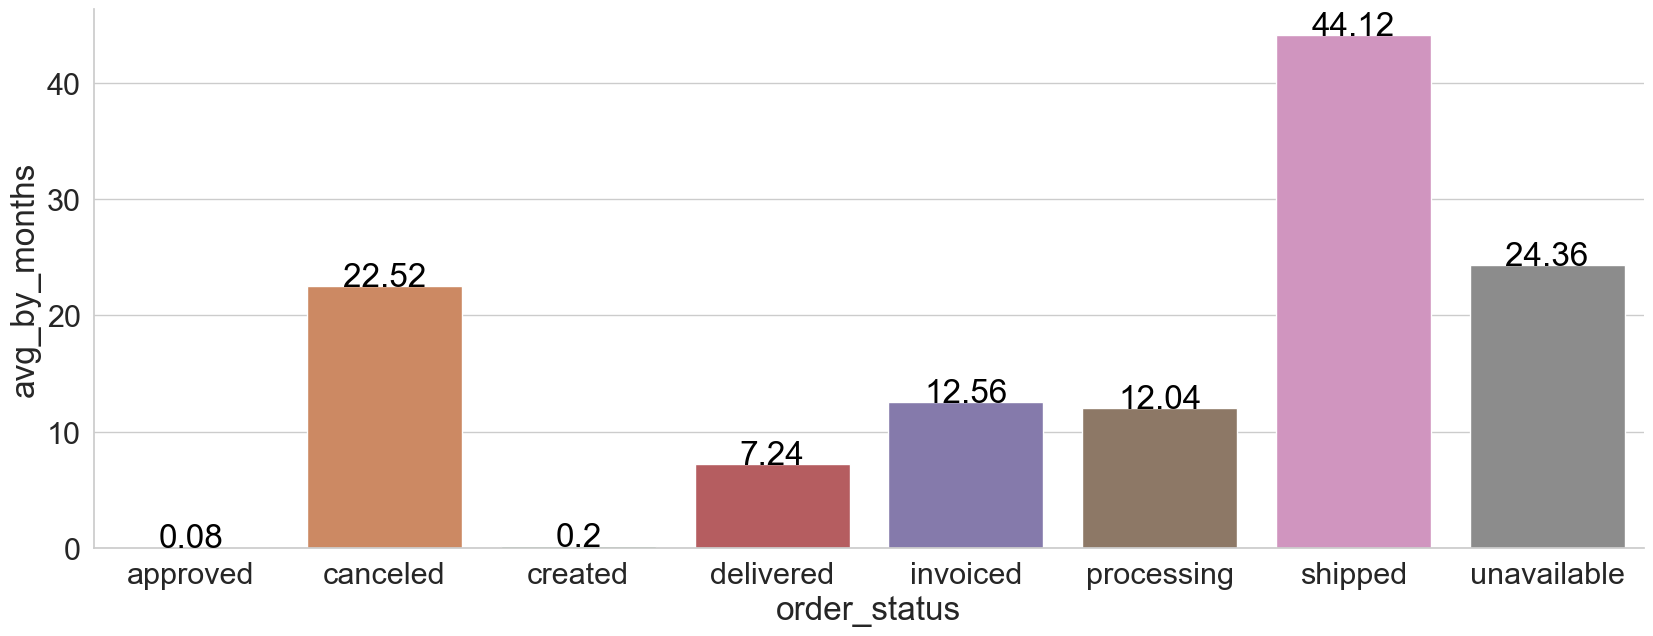

In [21]:
ax = sns.barplot(data=undelivered_by_status, y='avg_by_months', x='order_status')
for index, row in undelivered_by_status.iterrows():
    ax.text(row.name, row.avg_by_months, round(row.avg_by_months, 2), color='black', ha="center")
sns.despine()
# Недоставленные по статусам

# По каждому товару определить, в какой день недели товар чаще всего покупается.

Для подсчета будем использовать датафрейм 'purchases' с данными, которые считаем за покупку.

In [22]:
purchases['day_of_week'] = purchases['order_purchase_timestamp'].dt.day_name()
# Создаем колонку с днем недели

In [23]:
products_by_purchases = pd.merge(items[['order_id', 'product_id']], 
                                 purchases[['order_id', 'day_of_week']], 
                                 how='inner',
                                 on='order_id')
# Мерджим данные для подсчета

In [24]:
products_by_purchases.groupby(['product_id', 'day_of_week'], as_index=False) \
                     .order_id.count() \
                     .sort_values('order_id', ascending=False) \
                     .groupby('product_id').head(1) \
                     .rename(columns={'order_id':'frequency'})
# Находим в какой день недели товар чаще всего покупается

,product_id,day_of_week,frequency
15576,422879e10f46682990de24d770e7f83d,Wednesday,93
35704,99a4788cb24856965c36a24e339b6058,Monday,91
40128,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,88
19683,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
13252,389d119b48cf3043d311335e499d9c6b,Thursday,67
...,...,...,...
23456,6413f8d0daa3a38887a14917589e7da5,Wednesday,1
23458,641444946fe3a839d726c32804cd1aff,Tuesday,1
23459,6416e0ecd625ef4adf18658a9aca2e10,Thursday,1
23460,64187b994e1b15e6a59a6f72688fbea8,Friday,1


# Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?

In [25]:
purchases_by_month = pd.merge(customers[['customer_unique_id', 'customer_id']],
                              purchases[['customer_id', 'order_id', 'order_purchase_timestamp']], 
                              on='customer_id')
# Создаем новый датафрейм для подсчета покупок 

In [26]:
import calendar

purchases_by_month['weeks_in_month'] = round((purchases_by_month['order_purchase_timestamp'] \
                                       .apply(lambda x: calendar.monthrange(x.year, x.month)[1])) / 7, 2)
# Находим количество недель в месяце

In [27]:
purchases_by_month['year_month'] = purchases_by_month['order_purchase_timestamp'].dt.strftime('%Y-%m')
# Создаем колонку с удобным форматом даты для группировки

In [28]:
orders_by_months = purchases_by_month.groupby(['customer_unique_id', 'year_month', 'weeks_in_month'], as_index=False) \
                                     .order_id.count() \
                                     .rename(columns={'order_id':'orders'})
# Группируем по пользователю и месяцу и считаем заказы

In [29]:
orders_by_months['orders_per_week'] = round(orders_by_months['orders'] / orders_by_months['weeks_in_month'], 2)
# Считаем число заказов в неделю

In [30]:
orders_by_months

,customer_unique_id,year_month,weeks_in_month,orders,orders_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,4.43,1,0.23
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,4.43,1,0.23
2,0000f46a3911fa3c0805444483337064,2017-03,4.43,1,0.23
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,4.43,1,0.23
4,0004aac84e0df4da2b147fca70cf8255,2017-11,4.29,1,0.23
...,...,...,...,...,...
95011,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,4.29,1,0.23
95012,fffea47cd6d3cc0a88bd621562a9d061,2017-12,4.43,1,0.23
95013,ffff371b4d645b6ecea244b27531430a,2017-02,4.00,1,0.25
95014,ffff5962728ec6157033ef9805bacc48,2018-05,4.43,1,0.23


# Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

В задании не написано за какой год, но так как полная информация за период с января по декабрь есть только за 2017 год, то и считать будем за 2017 год. За покупку будем считать то же, что и в 1 задании. 

In [31]:
purchases_cohorts = pd.merge(customers[['customer_unique_id', 'customer_id']],
                             purchases[['customer_id', 'order_id', 'order_purchase_timestamp']],  
                             on='customer_id')
# Создаем датафрейм для подсчета

In [32]:
purchases_cohorts['order_month'] = purchases_cohorts['order_purchase_timestamp'].dt.strftime('%Y-%m')
# Создаем колонку с годом и месяцем соверешения покупки

In [33]:
purchases_cohorts = purchases_cohorts.query('order_month >= "2017-01" and order_month <= "2017-12"').reset_index(drop=True)
# Фильтруем данные

In [34]:
purchases_cohorts.set_index('customer_unique_id', inplace=True)
# Добавим индекс по customer_unique_id

purchases_cohorts['join_month'] = purchases_cohorts.groupby(level=0)['order_purchase_timestamp'] \
                                                   .min().apply(lambda x: x.strftime('%Y-%m'))
# Добавим столбец первой покупки join_month

purchases_cohorts.reset_index(inplace=True)
# Переиндексируем датафрейм

In [35]:
purchases_cohorts.insert(len(purchases_cohorts.columns), 'total_orders', 0, allow_duplicates=False)
# Создадим столбец в котором далее поместим количество заказов

In [36]:
grouped = purchases_cohorts.groupby(['join_month', 'order_month'])

cohorts = grouped.agg({'customer_unique_id': pd.Series.nunique,
                       'total_orders': pd.Series.count})
# Количество уникальных пользователей и общее количество заказов

In [37]:
cohorts.rename(columns={'customer_unique_id': 'total_users'}, inplace=True)
# Переименуем колонки

In [38]:
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 1
    return df
cohorts = cohorts.groupby(level=0).apply(cohort_period)
# Нумеруем когорты

C:\Users\User\AppData\Local\Temp\ipykernel_12148\3273015896.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  cohorts = cohorts.groupby(level=0).apply(cohort_period)


In [39]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohort_period', 'join_month'], inplace=True)
# Переиндексируем датафрейм

In [40]:
cohort_group_size = cohorts['total_users'].groupby(level=1).first()
cohort_group_size.head()
# Создадим ряд содержаший размер каждой когорты join_month

join_month
2017-01     713
2017-02    1612
2017-03    2488
2017-04    2250
2017-05    3446
Name: total_users, dtype: int64

In [41]:
user_retention = cohorts['total_users'].unstack(1) \
                                       .divide(cohort_group_size, axis=1) \
                                       .mul(100)
# Считаем retention

user_retention.style.highlight_max(axis=1, subset=pd.IndexSlice[3, :])
# Находим когорту с самым высоким retention на 3й месяц, это оказались пользователи, совершившие первую покупку в сентябре

join_month,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
cohort_period,,,,,,,,,,,,
1,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2,0.280505,0.186104,0.442122,0.622222,0.464306,0.495050,0.533333,0.690506,0.699825,0.716763,0.567859,nan
3,0.280505,0.310174,0.361736,0.222222,0.464306,0.396040,0.346667,0.345253,0.549863,0.254335,nan,nan
4,0.140252,0.124069,0.401929,0.177778,0.290192,0.429043,0.240000,0.271270,0.274931,nan,nan,nan
5,0.420757,0.434243,0.361736,0.266667,0.290192,0.297030,0.293333,0.345253,nan,nan,nan,nan
6,0.140252,0.124069,0.160772,0.266667,0.319211,0.396040,0.213333,nan,nan,nan,nan,nan
7,0.420757,0.248139,0.160772,0.355556,0.406268,0.363036,nan,nan,nan,nan,nan,nan
8,0.140252,0.186104,0.321543,0.311111,0.145096,nan,nan,nan,nan,nan,nan,nan
9,0.140252,0.062035,0.321543,0.311111,nan,nan,nan,nan,nan,nan,nan,nan


# Построить RFM-сегментацию пользователей, чтобы качественно оценить аудиторию.

In [42]:
df = items.groupby('order_id', as_index=False).price.sum()

rfm = pd.merge(purchases_by_month[['customer_unique_id', 'order_id', 'order_purchase_timestamp']],
                               df[['order_id', 'price']], 
                               on='order_id')
# Создаем новый датафрейм для дальнейшей работы

In [43]:
from datetime import timedelta

today_date = rfm['order_purchase_timestamp'].max() + timedelta(days=1)
today_date
# Примем за текущую дату

Timestamp('2018-08-30 15:00:37')

In [44]:
rfm = rfm.groupby('customer_unique_id', as_index=False) \
         .agg({'order_purchase_timestamp' : lambda x: (today_date - x.max()).total_seconds()/86400,
               'order_id' : 'count',
               'price' : 'sum'})

rfm.rename(columns={'order_purchase_timestamp' : 'recency',
                    'order_id' : 'frequency',
                    'price' : 'monetary'}, inplace=True)
# Редактируем дф 

In [45]:
rfm.head(5)
# Нужный дф для дальнейшей работы и оценки

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112.169560,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115.159144,1,18.90
2,0000f46a3911fa3c0805444483337064,537.746921,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321.771481,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288.802025,1,180.00


In [46]:
rfm['r'] = 5 - (pd.qcut(rfm['recency'], 4, labels=False) + 1)
# Оцениваем recency

По frequency имеется явно выраженное смещение, поэтому нужна функция для отдельной оценки frequency

In [47]:
def get_f(x):
    if x in [1]:
        return 1
    if x in [2, 3]:
        return 2
    if x in [4, 5, 6]:
        return 3
    return 4
# Функция для оценки frequency

In [48]:
rfm['f'] = rfm['frequency'].apply(get_f)
# Оцениваем frequency

In [49]:
rfm['m'] = pd.qcut(rfm['monetary'], 4, labels=False) + 1
# Оцениваем monetary

In [50]:
rfm['rfm_score'] = ((rfm['r'] + rfm['f'] + rfm['m']) / 3).round(2)
# Считаем rfm_score

In [51]:
rfm['RFM_Score'] = rfm['r'].map(str) + rfm['f'].map(str) + rfm['m'].map(str)
# Добавим новый столбец, содержащий комбинацию столбцов 'R', 'F' и 'M' в виде строковых значений

"champions": Клиенты с высокими значениями R, F и M. Это наиболее ценные клиенты, которые совершают частые и крупные покупки.

"loyal_customers": Клиенты, которые также имеют высокие значения R и F, но более низкий уровень M (от 1 до 2). Это постоянные клиенты, которые могут быть меньше склонны к повторным покупкам, но все еще остаются преданы компании.

"promising": Клиенты с высокими значениями R и M, но более низким значением F (от 1 до 2). Это новые клиенты, которые делают крупные покупки и имеют потенциал для развития долгосрочных отношений с компанией.

"new_customers": Клиенты с низкими значениями F и M (от 1 до 2). Это новые клиенты, которые могут иметь потенциал, но еще не показали своей лояльности. Они требуют большего внимания и усилий для удержания.

"can't_lose_them": Это клиенты, которые делают частые покупки, но возможно имеют низкую лояльность. Они являются ценными клиентами, но требуют внимания, чтобы удержать их.

"customers_needing_attention": Клиенты с более высоким значением F, но более низкими значениями R и M (от 1 до 2). Это клиенты, которые делают некоторые покупки, но возможно нуждаются в дополнительной мотивации или внимании, чтобы стать более лояльными.

"at_risk": Клиенты с более низкими значениями R и F, но высоким значением M (от 3 до 4). Это клиенты, которые делают редкие покупки, но могут иметь потенциал для развития. Они нуждаются в особенном внимании, чтобы продолжать делать покупки.

"hibernating": Клиенты с низкими значениями R, F и M (от 1 до 2). Это клиенты, которые не делают покупок в течение длительного времени и могут потенциально уйти к конкурентам. Они требуют серьезных усилий, чтобы вернуть их в активное состояние и заинтересовать в продуктах и услугах компании.

In [52]:
segments = {
    r'[3-4][3-4][3-4]': 'champions',
    r'[3-4][2-3][1-2]': 'loyal_customers',
    r'[3-4][1-2][3-4]': 'promising',
    r'[3-4][1-2][1-2]': 'new_customers',
    r'[1-2][3-4][3-4]': 'can’t_lose_them',
    r'[1-2][3-4][1-2]': 'customers_needing_attention',
    r'[1-2][1-2][3-4]': 'at_risk',
    r'[1-2][1-2][1-2]': 'hibernating'
}

# Определяем сегмент

# Добавим в датафрейм столбец, содержащий название сегмента:
rfm['Segment'] = rfm['RFM_Score'].replace(segments, regex=True)
rfm.head()

,customer_unique_id,recency,frequency,monetary,r,f,m,rfm_score,RFM_Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112.169560,1,129.90,4,1,3,2.67,413,promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115.159144,1,18.90,3,1,1,1.67,311,new_customers
2,0000f46a3911fa3c0805444483337064,537.746921,1,69.00,1,1,2,1.33,112,hibernating
3,0000f6ccb0745a6a4b88665a16c9f078,321.771481,1,25.99,2,1,1,1.33,211,hibernating
4,0004aac84e0df4da2b147fca70cf8255,288.802025,1,180.00,2,1,4,2.33,214,at_risk


In [53]:
segments = rfm.groupby('Segment')['monetary'] \
              .agg(['count']) \
              .sort_values('count', ascending = False) \
              .reset_index()
segments
# Создаем датафрейм с сегментами и количеством пользователей

,Segment,count
0,hibernating,23558
1,promising,23508
2,at_risk,23023
3,new_customers,22813
4,loyal_customers,233
5,champions,37
6,can’t_lose_them,7
7,customers_needing_attention,3


In [54]:
rfm.groupby('frequency', as_index=False) \
   .customer_unique_id.count() \
   .rename(columns={'customer_unique_id':'users'})
# Количество пользователей по числу покупок, как видно, большинство покупают очень мало

,frequency,users
0,1,90386
1,2,2568
2,3,181
3,4,28
4,5,9
5,6,5
6,7,3
7,9,1
8,15,1


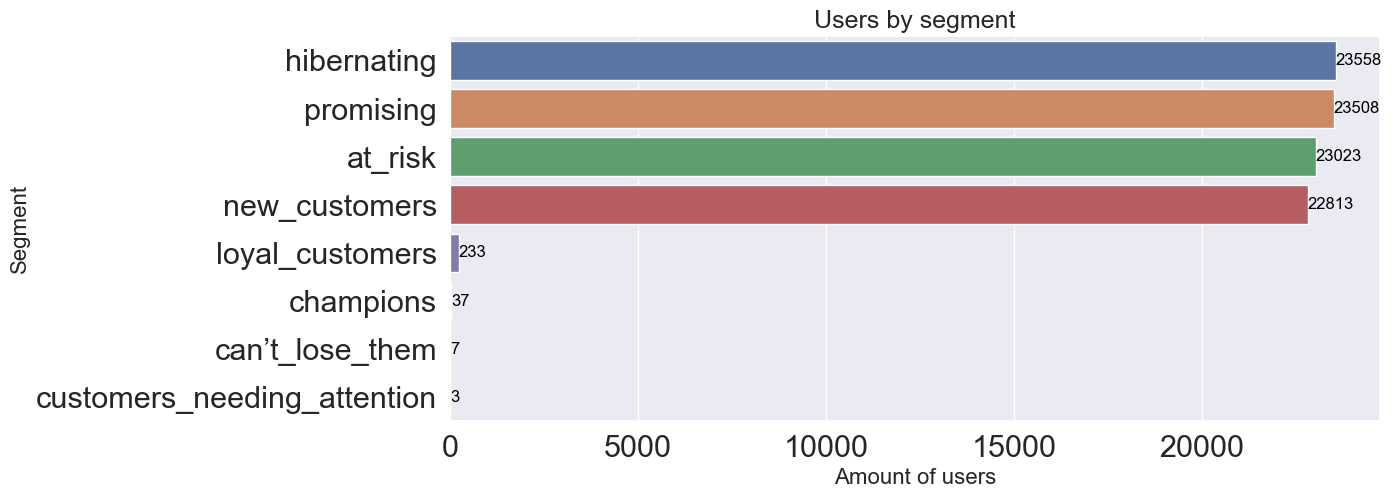

In [55]:
plt.figure(figsize=(12, 5))
sns.set_style("darkgrid")
ax = sns.barplot(data=segments, y='Segment', x='count')
plt.xlabel('Amount of users', size=16)
plt.ylabel('Segment', size=16)
plt.title('Users by segment', size=18)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Добавляем значения
for i, v in enumerate(segments['count']):
    ax.text(v + 0.2, i, str(v), color='black', fontsize=12, ha='left', va='center')

plt.show()

Из представленных данных можно сделать следующие выводы:

1. Большинство покупателей относятся к сегментам "hibernating", "promising" и "at_risk", то есть либо давно не совершали покупок, либо недостаточно часто и не слишком много тратят.
2. Очень малое количество покупателей относятся к сегментам "champions", "can’t_lose_them" и "customers_needing_attention", что говорит о том, что необходимо обратить на них особое внимание и разработать меры по удержанию и привлечению данной аудитории.
3. Сегмент "loyal_customers" также имеет небольшое количество покупателей, но они покупают на регулярной основе и реагируют на акции и специальные предложения.

На основании этой информации можно предложить следующие меры по улучшению ситуации:

1. Разработать маркетинговую стратегию для сегментов "champions", "can’t_lose_them" и "customers_needing_attention" с целью увеличения количества покупателей в этих группах.
2. Проводить акции и специальные предложения для удержания покупателей в сегменте "loyal_customers".
3. Анализировать причины, по которым покупатели попадают в сегменты "hibernating", "promising" и "at_risk", и разрабатывать меры для увеличения их участия в программе лояльности и повышения среднего чека.
4. Использовать инструменты автоматизации маркетинга, такие как email-рассылки, SMS-рассылки и push-уведомления, для поддержания связи с покупателями и уведомления их о новых акциях и предложениях.